# Предобученный UNet для семантической сегментации

В этом ноутбуке мы реализуем обучение предобученной модели UNet для семантической сегментации на датасете CamVid. Используем PyTorch Lightning для обучения модели.


## Установка зависимостей

Устанавливаем библиотеку segmentation_models_pytorch для работы с предобученными моделями сегментации.


In [1]:
!pip install -q segmentation-models-pytorch albumentations



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128
   ---------------------------------------- 3.5/3.5 GB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 7.5/7.5 MB 11.5 MB/s eta 0:00:00
   ---------------------------------------- 4.7/4.7 MB 10.3 MB/s eta 0:00:00
   ---------------------------------------- 6.3/6.3 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
print(torch.__version__, torch.version.cuda)

2.8.0+cu128 12.8


## Импорты и настройка

Импортируем необходимые библиотеки для работы с предобученным UNet, PyTorch Lightning и обработки данных.


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)


Seed set to 42


42

In [16]:
import numpy
numpy.version.version

'1.23.5'

## Аугментации данных

Определяем аугментации для обучения и валидации с использованием библиотеки albumentations.


In [17]:
def get_train_augmentation(img_size=(256, 256)):
    return A.Compose([
        A.Resize(img_size[0], img_size[1]),
        A.HorizontalFlip(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

def get_val_augmentation(img_size=(256, 256)):
    return A.Compose([
        A.Resize(img_size[0], img_size[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

## Датасет для сегментации

Используем CamVid для семантической сегментации. Датасет содержит 12 классов дорожных сцен.


In [18]:
class CamVidDataset(Dataset):
    def __init__(self, data_dir, split='train', img_size=(256, 256), transform=None):
        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform
        
        txt_file = os.path.join(data_dir, split + '.txt')
        self.samples = []
        
        with open(txt_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split()
                    if len(parts) >= 2:
                        img_path_abs = parts[0]
                        mask_path_abs = parts[1]
                        
                        img_filename = os.path.basename(img_path_abs)
                        mask_filename = os.path.basename(mask_path_abs)
                        
                        img_path = os.path.join(data_dir, split, img_filename)
                        mask_path = os.path.join(data_dir, split + 'annot', mask_filename)
                        
                        if os.path.exists(img_path) and os.path.exists(mask_path):
                            self.samples.append((img_path, mask_path))
        
        print("Loaded {} samples from {} split".format(len(self.samples), split))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        
        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'))
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            
            if isinstance(image, np.ndarray):
                image = torch.from_numpy(image).permute(2, 0, 1).float()
            if isinstance(mask, np.ndarray):
                mask = torch.from_numpy(mask).long()
        else:
            image = Image.fromarray(image).resize(self.img_size, Image.BILINEAR)
            image = np.array(image).astype(np.float32) / 255.0
            mask = Image.fromarray(mask).resize(self.img_size, Image.NEAREST)
            mask = np.array(mask).astype(np.int64)
            
            image = torch.from_numpy(image).permute(2, 0, 1)
            mask = torch.from_numpy(mask)
        
        return image, mask


## Архитектура предобученного UNet

Используем предобученную модель UNet из библиотеки segmentation_models_pytorch. UNet с предобученным энкодером ResNet34 обеспечивает хорошее качество сегментации.


In [20]:
encoder_name = "efficientnet-b3"   # альтернативы: "resnet50", "timm-efficientnet-b4"
encoder_weights = "imagenet"

model = smp.Unet(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    in_channels=3,
    classes=12,
)

print(f"Model: UNet with {encoder_name} encoder")
print(f"Encoder weights: {encoder_weights}")
print(f"Number of classes: 12")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")


Model: UNet with efficientnet-b3 encoder
Encoder weights: imagenet
Number of classes: 12
Number of parameters: 13,160,628


## Lightning модуль для обучения

Создаём PyTorch Lightning модуль для обучения модели UNet.


In [21]:
class UNetModule(pl.LightningModule):
    def __init__(self, model, learning_rate=3e-4, weight_decay=1e-4, class_weights=None):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])

        self.model = model
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.n_classes = 12

        self.dice_loss = smp.losses.DiceLoss(mode="multiclass", from_logits=True)
        self.class_weights = class_weights

    def forward(self, x):
        return self.model(x)

    def compute_iou(self, preds, targets):
        ious = []
        for cls in range(self.n_classes):
            pred_cls = (preds == cls)
            target_cls = (targets == cls)
            intersection = (pred_cls & target_cls).float().sum((1, 2))
            union = (pred_cls | target_cls).float().sum((1, 2))
            iou = (intersection + 1e-6) / (union + 1e-6)
            ious.append(iou.mean())
        return torch.stack(ious).mean()

    def _loss(self, logits, masks):
        ce = F.cross_entropy(logits, masks, weight=self.class_weights.to(self.device) if self.class_weights is not None else None)
        dice = self.dice_loss(logits, masks)
        return ce + dice, ce, dice

    def training_step(self, batch, batch_idx):
        images, masks = batch

        logits = self.forward(images)
        loss, ce, dice = self._loss(logits, masks)

        preds = torch.argmax(logits, dim=1)
        iou = self.compute_iou(preds, masks)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_ce', ce, on_step=True, on_epoch=True, prog_bar=False)
        self.log('train_dice', dice, on_step=True, on_epoch=True, prog_bar=False)
        self.log('train_iou', iou, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch

        logits = self.forward(images)
        loss, ce, dice = self._loss(logits, masks)

        preds = torch.argmax(logits, dim=1)
        iou = self.compute_iou(preds, masks)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_ce', ce, on_step=False, on_epoch=True, prog_bar=False)
        self.log('val_dice', dice, on_step=False, on_epoch=True, prog_bar=False)
        self.log('val_iou', iou, on_step=False, on_epoch=True, prog_bar=True)

        return {'val_loss': loss, 'val_iou': iou}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        # OneCycleLR: достаточно стабильный способ быстро выйти на хорошее качество
        if hasattr(self.trainer, 'estimated_stepping_batches') and self.trainer.estimated_stepping_batches:
            total_steps = self.trainer.estimated_stepping_batches
        else:
            total_steps = self.trainer.max_epochs * 1000

        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            total_steps=total_steps,
            pct_start=0.25,
            anneal_strategy='cos',
            div_factor=25.0,
            final_div_factor=1e4
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }


## Загрузка данных

Создаём даталоадеры для обучения и валидации.


In [22]:
data_dir = '../data'

img_size = (512, 512)

train_transform = get_train_augmentation(img_size=img_size)
val_transform = get_val_augmentation(img_size=img_size)

train_dataset = CamVidDataset(
    data_dir=data_dir,
    split='train',
    img_size=img_size,
    transform=train_transform
)

val_dataset = CamVidDataset(
    data_dir=data_dir,
    split='val',
    img_size=img_size,
    transform=val_transform
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

batch_size = 12
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=(num_workers > 0)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=(num_workers > 0)
)


Loaded 367 samples from train split
Loaded 101 samples from val split
Train samples: 367
Val samples: 101


C:\Anaconda3\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## Визуализация данных

Проверяем загрузку данных и визуализируем примеры изображений и масок.


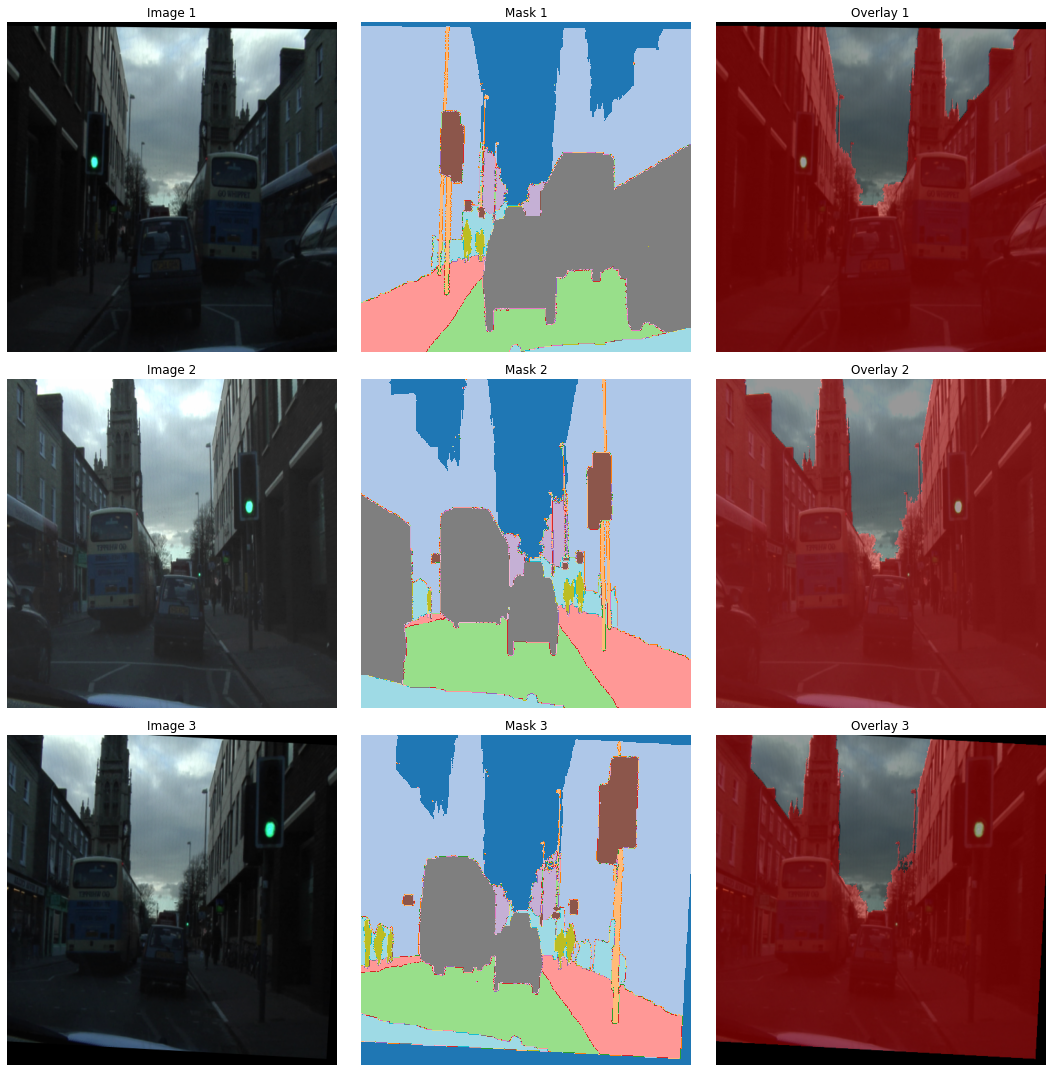

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([512, 512])
Mask unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 11])


In [23]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    image, mask = train_dataset[i]
    
    img_np = image.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)
    
    mask_np = mask.numpy()
    
    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f'Image {i+1}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=11)
    axes[i, 1].set_title(f'Mask {i+1}')
    axes[i, 1].axis('off')
    
    overlay = img_np.copy()
    mask_colored = np.zeros_like(img_np)
    mask_colored[mask_np > 0] = [1, 0, 0]
    overlay = overlay * 0.6 + mask_colored * 0.4
    
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f'Overlay {i+1}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Mask unique values: {torch.unique(mask)}")


## Инициализация модели

Создаём модель UNet и Lightning модуль для обучения.


In [37]:
unet_module = UNetModule(
    model=model,
    learning_rate=4e-4,
    weight_decay=2e-4
)


sample_input = torch.randn(1, 3, img_size[0], img_size[1])
with torch.no_grad():
    sample_output = unet_module(sample_input)

print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(f"Model parameters: {sum(p.numel() for p in unet_module.parameters()):,}")


Input shape: torch.Size([1, 3, 512, 512])
Output shape: torch.Size([1, 12, 512, 512])
Model parameters: 13,160,628


## Обучение модели

Настраиваем callbacks и запускаем обучение с использованием PyTorch Lightning.


In [10]:
import torch
torch.cuda.is_available()

True

In [38]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_iou',
    mode='max',
    save_top_k=1,
    filename='unet-{epoch:02d}-{val_iou:.4f}',
    save_last=True
)

early_stop_callback = EarlyStopping(
    monitor='val_iou',
    mode='max',
    patience=10,
    verbose=True
)

logger = TensorBoardLogger('lightning_logs', name='unet_segmentation')

trainer = pl.Trainer(
    max_epochs=60,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    precision='16-mixed' if torch.cuda.is_available() else 32, 
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=logger,
    log_every_n_steps=10,
    gradient_clip_val=1.0,
    accumulate_grad_batches=1,
    val_check_interval=0.5
)

trainer.fit(unet_module, train_loader, val_loader)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name      | Type     | Params | Mode  | FLOPs
-------------------------------------------------------
0 | model     | Unet     | 13.2 M | train | 0    
1 | dice_loss | DiceLoss | 0      | train | 0    
-------------------------------------------------------
13.2 M    Trainable params
0         Non-trainable params
13.2 M    Total params
52.643    Total estimated model params size (MB)
474       Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved. New best score: 0.641


Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved by 0.021 >= min_delta = 0.0. New best score: 0.662


Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved by 0.014 >= min_delta = 0.0. New best score: 0.675


Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.681


Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.685


Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.686


Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.686


Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.689


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.692


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.695


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.696


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.698


Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.701


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.703


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.710


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Monitored metric val_iou did not improve in the last 10 records. Best score: 0.710. Signaling Trainer to stop.


## Оценка на тестовом датасете

Оцениваем качество модели на тестовом датасете.


In [39]:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")


Best model path: lightning_logs\unet_segmentation\version_15\checkpoints\unet-epoch=15-val_iou=0.7097.ckpt


## Визуализация результатов

Визуализируем предсказания модели на нескольких примерах из валидационного датасета.


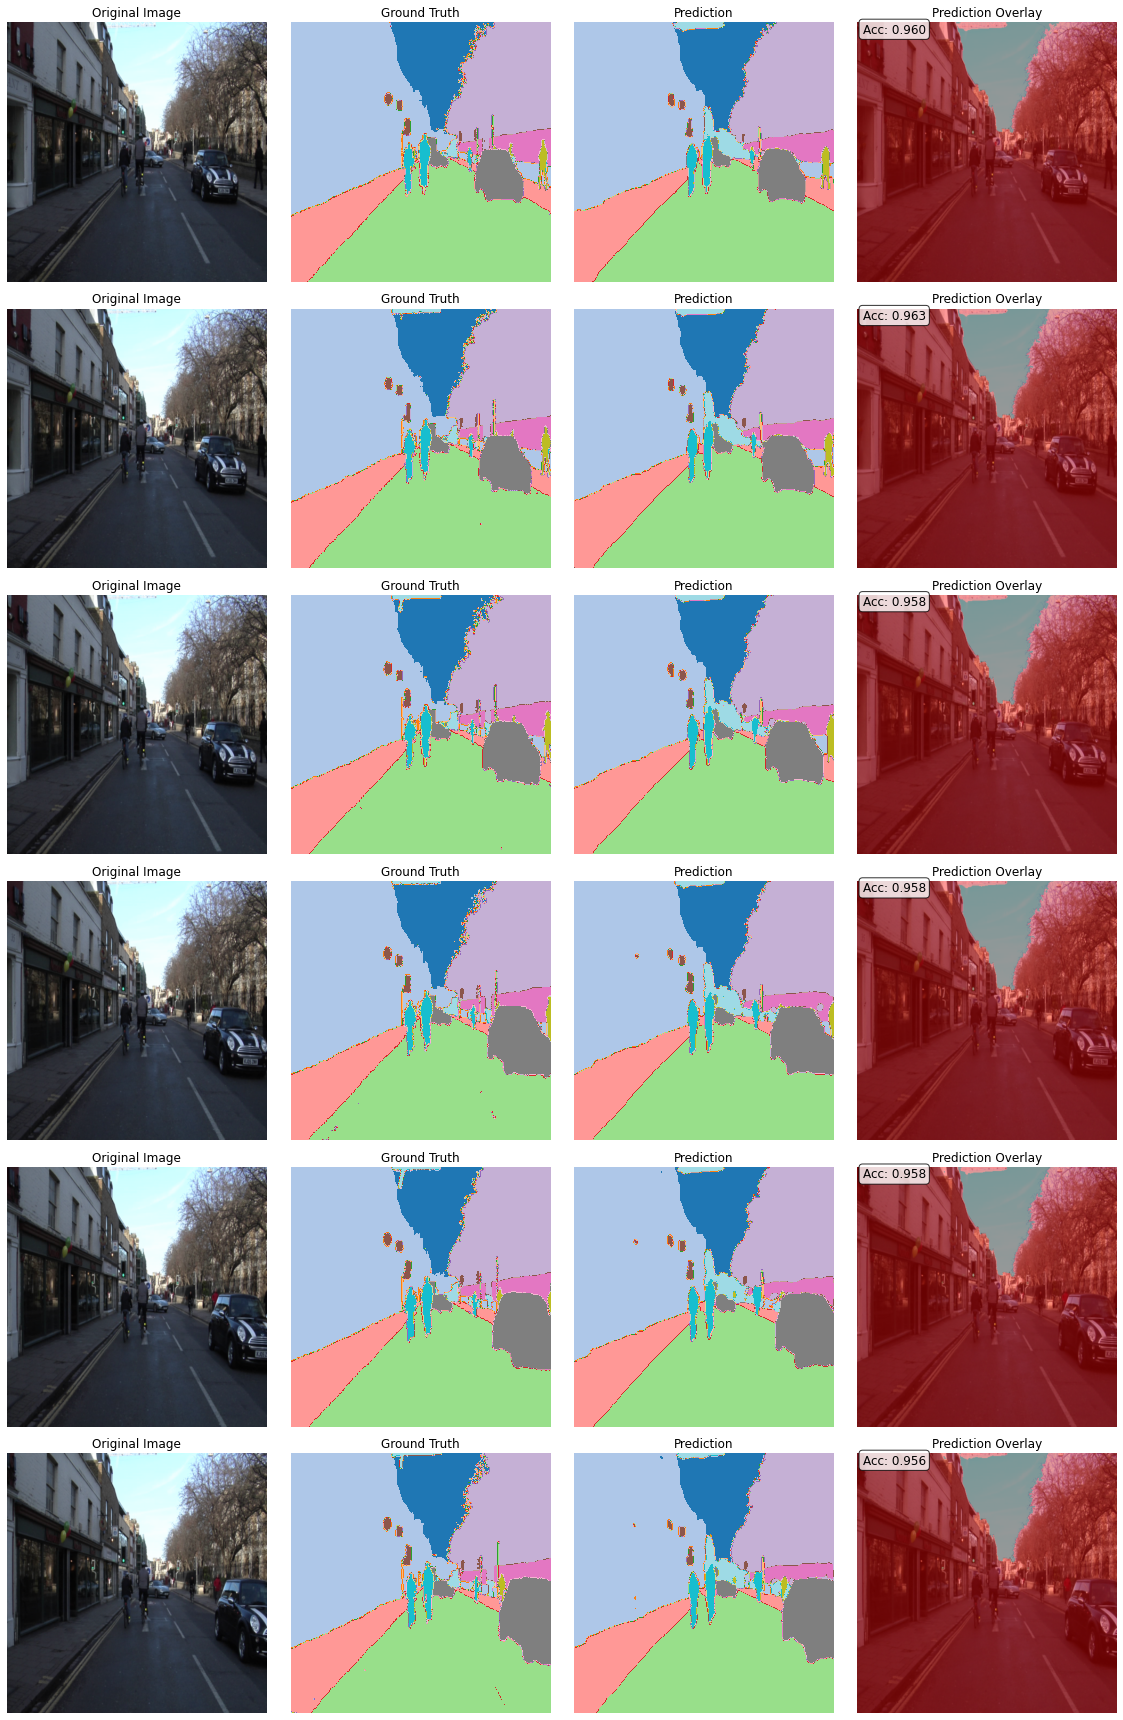

In [40]:
unet_module.eval()
device = next(unet_module.parameters()).device

num_samples = 6
fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

with torch.no_grad():
    for idx in range(num_samples):
        image, mask = val_dataset[idx]
        image_batch = image.unsqueeze(0).to(device)
        
        logits = unet_module(image_batch)
        pred = torch.argmax(logits, dim=1).cpu().squeeze()
        
        img_np = image.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)
        
        mask_np = mask.numpy()
        pred_np = pred.numpy()
        
        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=11)
        axes[idx, 1].set_title('Ground Truth')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(pred_np, cmap='tab20', vmin=0, vmax=11)
        axes[idx, 2].set_title('Prediction')
        axes[idx, 2].axis('off')
        
        overlay = img_np.copy()
        pred_colored = np.zeros_like(img_np)
        pred_colored[pred_np > 0] = [1, 0, 0]
        overlay = overlay * 0.6 + pred_colored * 0.4
        
        axes[idx, 3].imshow(overlay)
        axes[idx, 3].set_title('Prediction Overlay')
        axes[idx, 3].axis('off')
        
        correct = (pred_np == mask_np).sum()
        total = mask_np.size
        pixel_acc = correct / total
        axes[idx, 3].text(10, 20, f'Acc: {pixel_acc:.3f}', 
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                          fontsize=12, color='black')

plt.tight_layout()
plt.show()


## Метрики на валидационном датасете

Вычисляем детальные метрики на валидационном датасете.


In [41]:
def compute_metrics(preds, targets, n_classes=12):
    ious = []
    for cls in range(n_classes):
        pred_cls = (preds == cls)
        target_cls = (targets == cls)
        intersection = (pred_cls & target_cls).float().sum((1, 2))
        union = (pred_cls | target_cls).float().sum((1, 2))
        iou = (intersection + 1e-6) / (union + 1e-6)
        ious.append(iou.mean().item())
    
    mean_iou = np.mean(ious)
    
    correct = (preds == targets).float().sum((1, 2))
    total = targets.numel() // targets.shape[0]
    pixel_acc = correct.sum().item() / (targets.shape[0] * total)
    
    return {
        'mean_iou': mean_iou,
        'iou_per_class': ious,
        'pixel_acc': pixel_acc
    }

unet_module.eval()
all_preds = []
all_targets = []

val_loader_eval = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

with torch.no_grad():
    for images, masks in tqdm(val_loader_eval, desc="Evaluating"):
        images = images.to(device)
        logits = unet_module(images)
        preds = torch.argmax(logits, dim=1).cpu()
        
        all_preds.append(preds)
        all_targets.append(masks)

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

metrics = compute_metrics(all_preds, all_targets, n_classes=12)

camvid_classes = ['Sky', 'Building', 'Column-Pole', 'Road', 'Sidewalk', 'Tree', 'Sign-Symbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Void']

print("="*60)
print("Validation Metrics:")
print("="*60)
print(f"Mean IoU: {metrics['mean_iou']:.4f}")
print(f"Pixel Accuracy: {metrics['pixel_acc']:.4f}")
print("\nIoU per class:")
for cls_name, iou in zip(camvid_classes, metrics['iou_per_class']):
    print(f"  {cls_name}: {iou:.4f}")
print("="*60)


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 9/9 [00:36<00:00,  4.02s/it]


Validation Metrics:
Mean IoU: 0.7004
Pixel Accuracy: 0.9367

IoU per class:
  Sky: 0.9420
  Building: 0.8606
  Column-Pole: 0.1780
  Road: 0.9751
  Sidewalk: 0.8816
  Tree: 0.9109
  Sign-Symbol: 0.5775
  Fence: 0.7251
  Car: 0.7455
  Pedestrian: 0.5044
  Bicyclist: 0.8256
  Void: 0.2782
